# NQ&A Prediction

In [19]:
import numpy as np
import pandas as pd
import tqdm
import matplotlib as plt
import seaborn as sns
import tensorflow as tf

%matplotlib inline
sns.set()

from scripts import tf2_0_baseline_w_bert_translated_to_tf2_0 as tf2baseline # Oliviera's script
from scripts.tf2_0_baseline_w_bert_translated_to_tf2_0 import AnswerType
from scripts import bert_modeling as modeling
from scripts import bert_optimization as optimization
from scripts import bert_tokenization as tokenization

from collections import OrderedDict
import itertools
import json
import absl
import sys
import os

In [2]:
def read_partial_nq_examples(input_file, is_training, n=-1):
    """Read a NQ json file into a list of NqExample."""
    input_paths = tf.io.gfile.glob(input_file)
    input_data = []

    def _open(path):
        if path.endswith(".gz"):
            return gzip.GzipFile(fileobj=tf.io.gfile.GFile(path, "rb"))
        else:
            return tf.io.gfile.GFile(path, "r")

    for path in input_paths:
        absl.logging.info("Reading: %s", path)
        with _open(path) as input_file:
            for index, line in enumerate(input_file):
                if n > -1 and index >= n:
                        break
                input_data.append(tf2baseline.create_example_from_jsonl(line))

    examples = []
    for entry in input_data:
        examples.extend(tf2baseline.read_nq_entry(entry, is_training))
    return examples

tf2baseline.read_nq_examples = read_partial_nq_examples

def read_partial_candidates_from_one_split(input_path, n=-1):
    """Read candidates from a single jsonl file."""
    candidates_dict = {}
    if input_path.endswith(".gz"):
        with gzip.GzipFile(fileobj=tf.io.gfile.GFile(input_path, "rb")) as input_file:
            absl.logging.info("Reading examples from: %s", input_path)
            for index, line in enumerate(input_file):
                if n > -1 and index >= n:
                        break
                
                e = json.loads(line)
                candidates_dict[e["example_id"]] = e["long_answer_candidates"]
    else:
        with tf.io.gfile.GFile(input_path, "r") as input_file:
            absl.logging.info("Reading examples from: %s", input_path)
            for index, line in enumerate(input_file):
                if n > -1 and index >= n:
                        break
                        
                e = json.loads(line)
                candidates_dict[e["example_id"]] = e["long_answer_candidates"]
                
    return candidates_dict

tf2baseline.read_candidates_from_one_split = read_partial_candidates_from_one_split

def read_partial_candidates(input_pattern, n=-1):
    """Read candidates with real multiple processes."""
    input_paths = tf.io.gfile.glob(input_pattern)
    final_dict = {}
    for i, input_path in enumerate(input_paths):
        final_dict.update(tf2baseline.read_candidates_from_one_split(input_path, n=n-len(final_dict.keys())))
        if len(final_dict.keys()) >= n:
                break

    return final_dict

tf2baseline.read_candidates = read_partial_candidates

def raw_data_generator(path, chunk_size=1000):
        """Reads raw JSON examples to a DataFrame"""
        curr_pos = 0
        last_line = False
        with open(path, 'rt') as f:
                while not last_line:
                        df = []
                        for i in range(curr_pos, curr_pos+chunk_size):
                                line = f.readline()
                                if line is None:
                                        last_line = True
                                        break
                                df.append(json.loads(line))
                        curr_pos = i + 1
                        yield pd.DataFrame(df)

In [3]:
def del_all_flags(FLAGS):
    flags_dict = FLAGS._flags()
    keys_list = [keys for keys in flags_dict]
    for keys in keys_list:
        FLAGS.__delattr__(keys)

del_all_flags(absl.flags.FLAGS)

flags = absl.flags

flags.DEFINE_string(
    "bert_config_file", "models/bert_joint_baseline/bert_config.json",
    "The config json file corresponding to the pre-trained BERT model. "
    "This specifies the model architecture.")

flags.DEFINE_string("vocab_file", "models/bert_joint_baseline/vocab-nq.txt",
                    "The vocabulary file that the BERT model was trained on.")

flags.DEFINE_string(
    "output_dir", "output/",
    "The output directory where the model checkpoints will be written.")

flags.DEFINE_string(
    "output_prediction_file", "predictions.json",
    "Where to print predictions in NQ prediction format, to be passed to"
    "natural_questions.nq_eval.")

flags.DEFINE_string(
    "init_checkpoint", "models/bert_joint_baseline/tf2_bert_joint.ckpt",
    "Initial checkpoint (usually from a pre-trained BERT model).")

flags.DEFINE_string(
    "train_file", "data/simplified-nq-train.jsonl",
    "NQ json for predictions. E.g., dev-v1.1.jsonl.gz or test-v1.1.jsonl.gz")

flags.DEFINE_string("train_precomputed_file", "data/train.tf_record",
                    "Precomputed tf records for training.")

flags.DEFINE_integer("train_num_precomputed", 10,
                     "Number of precomputed tf records for training.")

flags.DEFINE_bool(
    "do_lower_case", True,
    "Whether to lower case the input text. Should be True for uncased "
    "models and False for cased models.")

flags.DEFINE_integer(
    "max_seq_length", 384,
    "The maximum total input sequence length after WordPiece tokenization. "
    "Sequences longer than this will be truncated, and sequences shorter "
    "than this will be padded.")

flags.DEFINE_integer(
    "doc_stride", 128,
    "When splitting up a long document into chunks, how much stride to "
    "take between chunks.")

flags.DEFINE_integer(
    "max_query_length", 64,
    "The maximum number of tokens for the question. Questions longer than "
    "this will be truncated to this length.")

flags.DEFINE_bool("do_train", False, "Whether to run training.")

flags.DEFINE_bool("do_predict", True, "Whether to run eval on the dev set.")

flags.DEFINE_integer("train_batch_size", 32, "Total batch size for training.")

flags.DEFINE_integer("predict_batch_size", 8,
                     "Total batch size for predictions.")

flags.DEFINE_float("learning_rate", 5e-5, "The initial learning rate for Adam.")

flags.DEFINE_integer("num_train_epochs", 3,
                   "Total number of training epochs to perform.")

flags.DEFINE_float(
    "warmup_proportion", 0.1,
    "Proportion of training to perform linear learning rate warmup for. "
    "E.g., 0.1 = 10% of training.")

flags.DEFINE_integer("save_checkpoints_steps", 1000,
                     "How often to save the model checkpoint.")

flags.DEFINE_integer("iterations_per_loop", 1000,
                     "How many steps to make in each estimator call.")

flags.DEFINE_integer(
    "n_best_size", 20,
    "The total number of n-best predictions to generate in the "
    "nbest_predictions.json output file.")

flags.DEFINE_integer(
    "verbosity", 1, "How verbose our error messages should be")

flags.DEFINE_integer(
    "max_answer_length", 30,
    "The maximum length of an answer that can be generated. This is needed "
    "because the start and end predictions are not conditioned on one another.")

flags.DEFINE_float(
    "include_unknowns", 1.0,
    "If positive, probability of including answers of type `UNKNOWN`.")

flags.DEFINE_bool("use_tpu", False, "Whether to use TPU or GPU/CPU.")
flags.DEFINE_bool("use_one_hot_embeddings", False, "Whether to use use_one_hot_embeddings")

absl.flags.DEFINE_string(
    "gcp_project", None,
    "[Optional] Project name for the Cloud TPU-enabled project. If not "
    "specified, we will attempt to automatically detect the GCE project from "
    "metadata.")

flags.DEFINE_bool(
    "verbose_logging", False,
    "If true, all of the warnings related to data processing will be printed. "
    "A number of warnings are expected for a normal NQ evaluation.")

# TODO(Edan): Look at nested contents too at some point
# Around 5% of long answers are nested, and around 50% of questions have
# long answers
# This means that this setting alone restricts us from a correct answer
# around 2.5% of the time
flags.DEFINE_boolean(
    "skip_nested_contexts", True,
    "Completely ignore context that are not top level nodes in the page.")

flags.DEFINE_integer("task_id", 0,
                     "Train and dev shard to read from and write to.")

flags.DEFINE_integer("max_contexts", 48,
                     "Maximum number of contexts to output for an example.")

flags.DEFINE_integer(
    "max_position", 50,
    "Maximum context position for which to generate special tokens.")

flags.DEFINE_integer(
    "n_examples", 400,
    "Number of examples to read from files.")

flags.DEFINE_boolean(
    "test_post_processing", True,
    "If true, training data will be predicted for instead of eval data,"
    "and the predictions will be used to tune the post processing algorithm.")

## Special flags - do not change

flags.DEFINE_string(
    "predict_file", "/kaggle/input/tensorflow2-question-answering/simplified-nq-test.jsonl",
    "NQ json for predictions. E.g., dev-v1.1.jsonl.gz or test-v1.1.jsonl.gz")
flags.DEFINE_boolean("logtostderr", True, "Logs to stderr")
flags.DEFINE_boolean("undefok", True, "it's okay to be undefined")
flags.DEFINE_string('f', '', 'kernel')
flags.DEFINE_string('HistoryManager.hist_file', '', 'kernel')

FLAGS = flags.FLAGS
FLAGS(sys.argv) # Parse the flags

['/home/ejmejm/anaconda3/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py']

## Build the Model

In [4]:
class TDense(tf.keras.layers.Layer):
    def __init__(self,
                 output_size,
                 kernel_initializer=None,
                 bias_initializer="zeros",
                **kwargs):
        super().__init__(**kwargs)
        self.output_size = output_size
        self.kernel_initializer = kernel_initializer
        self.bias_initializer = bias_initializer

    def build(self,input_shape):
        dtype = tf.as_dtype(self.dtype or tf.keras.backend.floatx())
        if not (dtype.is_floating or dtype.is_complex):
            raise TypeError("Unable to build `TDense` layer with "
                          "non-floating point (and non-complex) "
                          "dtype %s" % (dtype,))
        input_shape = tf.TensorShape(input_shape)
        if tf.compat.dimension_value(input_shape[-1]) is None:
            raise ValueError("The last dimension of the inputs to "
                           "`TDense` should be defined. "
                           "Found `None`.")
        last_dim = tf.compat.dimension_value(input_shape[-1])
        ### tf 2.1 rc min_ndim=3 -> min_ndim=2
        self.input_spec = tf.keras.layers.InputSpec(min_ndim=2, axes={-1: last_dim})
        self.kernel = self.add_weight(
            "kernel",
            shape=[self.output_size,last_dim],
            initializer=self.kernel_initializer,
            dtype=self.dtype,
            trainable=True)
        self.bias = self.add_weight(
            "bias",
            shape=[self.output_size],
            initializer=self.bias_initializer,
            dtype=self.dtype,
            trainable=True)
        super(TDense, self).build(input_shape)
    def call(self,x):
        return tf.matmul(x,self.kernel,transpose_b=True)+self.bias

def build_model(bert_config):
    input_ids = tf.keras.Input(shape=(FLAGS.max_seq_length,),dtype=tf.int32,name='input_ids')
    input_mask = tf.keras.Input(shape=(FLAGS.max_seq_length,),dtype=tf.int32,name='input_mask')
    segment_ids = tf.keras.Input(shape=(FLAGS.max_seq_length,),dtype=tf.int32,name='segment_ids')
    bert_layer = modeling.BertModel(config=bert_config, name='bert')
    pooled_output, sequence_output = bert_layer(input_word_ids=input_ids,
                                                input_mask=input_mask,
                                                input_type_ids=segment_ids)
    
    # Maybe try sharing the start and end logits variables
    seq_layer = TDense(2, name='td_seq')
    # seq_layer = tf.keras.layers.TimeDistributed(seq_layer, name='td_seq')
    
    seq_logits = seq_layer(sequence_output)
    start_logits, end_logits = tf.split(seq_logits, axis=-1, num_or_size_splits=2, name='split')
    start_logits = tf.squeeze(start_logits, axis=-1, name='start_logits')
    end_logits = tf.squeeze(end_logits, axis=-1, name='end_logits')
    
    ans_type_layer = TDense(len(tf2baseline.AnswerType), name='ans_type_logits')
    ans_type_logits = ans_type_layer(pooled_output)
    
    return tf.keras.Model([input_ids, input_mask, segment_ids],
                          [start_logits, end_logits, ans_type_logits],
                          name='bert_baseline')

In [5]:
bert_config = modeling.BertConfig.from_json_file(FLAGS.bert_config_file)

model = build_model(bert_config)
model.load_weights(FLAGS.init_checkpoint) # .assert_consumed() will not work right now
model.summary()

ResourceExhaustedError: in converted code:

    /home/ejmejm/MLProjects/kaggle-nqa/scripts/bert_modeling.py:386 call  *
        word_embeddings = self.embedding_lookup(input_word_ids)
    /home/ejmejm/anaconda3/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/keras/engine/base_layer.py:817 __call__
        self._maybe_build(inputs)
    /home/ejmejm/anaconda3/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/keras/engine/base_layer.py:2141 _maybe_build
        self.build(input_shapes)
    /home/ejmejm/MLProjects/kaggle-nqa/scripts/bert_modeling.py:431 build
        dtype=self.dtype)
    /home/ejmejm/anaconda3/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/keras/engine/base_layer.py:522 add_weight
        aggregation=aggregation)
    /home/ejmejm/anaconda3/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/training/tracking/base.py:744 _add_variable_with_custom_getter
        **kwargs_for_getter)
    /home/ejmejm/anaconda3/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/keras/engine/base_layer_utils.py:139 make_variable
        shape=variable_shape if variable_shape else None)
    /home/ejmejm/anaconda3/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/ops/variables.py:258 __call__
        return cls._variable_v1_call(*args, **kwargs)
    /home/ejmejm/anaconda3/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/ops/variables.py:219 _variable_v1_call
        shape=shape)
    /home/ejmejm/anaconda3/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/ops/variables.py:197 <lambda>
        previous_getter = lambda **kwargs: default_variable_creator(None, **kwargs)
    /home/ejmejm/anaconda3/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/ops/variable_scope.py:2507 default_variable_creator
        shape=shape)
    /home/ejmejm/anaconda3/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/ops/variables.py:262 __call__
        return super(VariableMetaclass, cls).__call__(*args, **kwargs)
    /home/ejmejm/anaconda3/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1406 __init__
        distribute_strategy=distribute_strategy)
    /home/ejmejm/anaconda3/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1537 _init_from_args
        initial_value() if init_from_fn else initial_value,
    /home/ejmejm/anaconda3/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/keras/engine/base_layer_utils.py:119 <lambda>
        init_val = lambda: initializer(shape, dtype=dtype)
    /home/ejmejm/anaconda3/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/ops/init_ops_v2.py:343 __call__
        self.stddev, dtype)
    /home/ejmejm/anaconda3/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/ops/init_ops_v2.py:809 truncated_normal
        shape=shape, mean=mean, stddev=stddev, dtype=dtype, seed=self.seed)
    /home/ejmejm/anaconda3/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/ops/random_ops.py:175 truncated_normal
        shape_tensor, dtype, seed=seed1, seed2=seed2)
    /home/ejmejm/anaconda3/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/ops/gen_random_ops.py:1006 truncated_normal
        _six.raise_from(_core._status_to_exception(e.code, message), None)
    <string>:3 raise_from
        

    ResourceExhaustedError: OOM when allocating tensor with shape[30522,1024] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:TruncatedNormal]


In [8]:
if FLAGS.do_predict:
    if not FLAGS.output_prediction_file:
        raise ValueError(
            "--output_prediction_file must be defined in predict mode.")
    
    tokenizer = tokenization.FullTokenizer(
        vocab_file=FLAGS.vocab_file, do_lower_case=FLAGS.do_lower_case)

    if FLAGS.output_prediction_file:
        input_file = FLAGS.train_file
    else:
        input_file = FLAGS.predict_file

    # This is actually quite slow, but I'm not sure if it's due to tokenizing or reading from a compressed file
    eval_examples = tf2baseline.read_nq_examples(
          input_file=input_file, is_training=FLAGS.test_post_processing, n=FLAGS.n_examples)

    print(len(eval_examples))

    print("FLAGS.predict_file", FLAGS.predict_file)

    eval_writer = tf2baseline.FeatureWriter(
      filename=os.path.join(FLAGS.output_dir, "eval.tf_record"),
      is_training=FLAGS.test_post_processing)
    eval_features = []

    def append_feature(feature):
        eval_features.append(feature)
        eval_writer.process_feature(feature)

    num_spans_to_ids = tf2baseline.convert_examples_to_features(
      examples=eval_examples,
      tokenizer=tokenizer,
      is_training=FLAGS.test_post_processing,
      output_fn=append_feature)
    eval_writer.close()
    eval_filename = eval_writer.filename

    print('**Features**\n')

    for e in dir(eval_features[0]):
        if not e.startswith('__'):
            print(e)

400
FLAGS.predict_file /kaggle/input/tensorflow2-question-answering/simplified-nq-test.jsonl
**Features**

answer_text
answer_type
doc_span_index
end_position
example_index
input_ids
input_mask
segment_ids
start_position
token_is_max_context
token_to_orig_map
tokens
unique_id


### **eval_features**
- `doc_span_index`: Which index this span is in the set that makes up one question-article pair
- `example_index`: Index of the example 
- `input_mask`: 0 if a token is padding, otherwise 1 for each token in the article
- `segment_ids`: Tokens that are part of a question are 0 ([CLS], [Q], ..., [SEP])
- `inpud_ids`: Token ids of the article
    - 0 -> [PAD]
    - 101 -> [CLS]
    - 102 -> [SEP]
    - 103 -> [MASK]
    - 104 -> [Q]
    - 105 -> [YES]
    - 106 -> [NO]
    - 107 -> [NoLongAnswer]
    - 108 -> [NoShortAnswer]
- `token_is_max_context`: False if this token will appear again in the next document span due to a sliding window being used, and True otherwise
- `token_to_orig_map`: Maps the tokens in `tokens` and `input_ids` to the actual token indices in the original document
- `tokens`: A list of tokens making up the document span
- `unique_id`: A unique id number for this article (NOT this document span) 

*Note - mappings are 0 indexed and exlude tokens that are part of the question (those can be identified from segment ids)

In [11]:
eval_examples[0].answer.text

"a newsletter sent to an advertising firm 's customers"

In [14]:
eval_examples[0].questions

['which is the most common use of opt-in e-mail marketing']

In [23]:
answers

[]

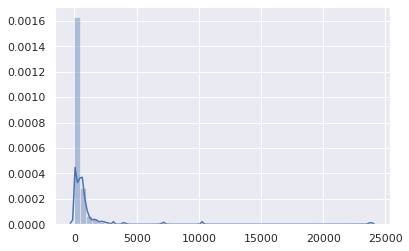

In [24]:
answers = []
for example in eval_examples:
    if example.answer.type in (AnswerType.LONG, AnswerType.YES, AnswerType.NO):
        answers.append(example.answer.text)
    elif example.answer.type == AnswerType.SHORT:
        answers.append(example.answer.text)
    
answer_lens = [len(x) for x in answers]
sns.distplot(answer_lens)

In [32]:
np.quantile(answer_lens, 0.98)

2959.3599999999988

In [ ]:
name_to_features = {
    "unique_ids": tf.io.FixedLenFeature([], tf.int64),
    "input_ids": tf.io.FixedLenFeature([FLAGS.max_seq_length], tf.int64),
    "input_mask": tf.io.FixedLenFeature([FLAGS.max_seq_length], tf.int64),
    "segment_ids": tf.io.FixedLenFeature([FLAGS.max_seq_length], tf.int64),
}
if FLAGS.do_train:
    name_to_features["start_positions"] = tf.io.FixedLenFeature([], tf.int64)
    name_to_features["end_positions"] = tf.io.FixedLenFeature([], tf.int64)
    name_to_features["answer_types"] = tf.io.FixedLenFeature([], tf.int64)

def decode_record(record, name_to_features):
    """Decodes a record to a TensorFlow example."""
    example = tf.io.parse_single_example(serialized=record, features=name_to_features)

    # tf.Example only supports tf.int64, but the TPU only supports tf.int32.
    # So cast all int64 to int32.
    for name in list(example.keys()):
        t = example[name]
        if t.dtype == tf.int64:
            t = tf.cast(t, dtype=tf.int32)
        example[name] = t

    return example

def data_generator(batch_size=32, n_samples=-1, seed=42):
    """The actual input function."""

    # For training, we want a lot of parallel reading and shuffling.
    # For eval, we want no shuffling and parallel reading doesn't matter.
#     if FLAGS.test_post_processing:
#         eval_filename = FLAGS.train_precomputed_file
        
    dataset = tf.data.TFRecordDataset(eval_filename)
    if FLAGS.do_train:
        dataset = dataset.repeat()
        dataset = dataset.shuffle(buffer_size=5000, seed=seed)
        
    dataset = dataset.map(lambda r: decode_record(r, name_to_features))
    dataset = dataset.batch(batch_size=batch_size, drop_remainder=False)
    
    data_iter = iter(dataset)
    sample_idx = 0
    while sample_idx < n_samples or n_samples == -1:
        try:
            examples = next(data_iter)
        except StopIteration:
            break
            
        cutoff_amt = batch_size
        if n_samples > -1:
            cutoff_amt = min(cutoff_amt, n_samples - sample_idx)
        sample_idx += cutoff_amt
    
        for k, v in examples.items():
            examples[k] = v[:cutoff_amt]
        
        inputs = {
            # 'unique_id': examples['unique_ids'],
            'input_ids': examples['input_ids'],
            'input_mask': examples['input_mask'],
            'segment_ids': examples['segment_ids']
        }

        if FLAGS.do_train:
            targets = {
                'tf_op_layer_start_logits': examples['start_positions'],
                'tf_op_layer_end_logits': examples['end_positions'],
                'ans_type_logits': examples['answer_types'],
            }

            yield inputs, targets
        else:
            yield inputs

In [18]:
n_steps = np.ceil(eval_writer.num_features / FLAGS.predict_batch_size)
generator = data_generator(FLAGS.predict_batch_size)

preds = model.predict_generator(generator, steps=n_steps)

### Answer Types
- UNKNOWN = 0
- YES = 1
- NO = 2
- SHORT = 3
- LONG = 4

## Functions for Computing Answers from Logits

In [221]:
def logits_to_probs(x):
    return np.exp(x) / (np.exp(x) + 1)

def get_candidate_span(entry):
    return (entry['candidates'][entry['candidate_idx']]['start_token'],
            entry['candidates'][entry['candidate_idx']]['end_token'])

def check_entry_in_candidates(entry):
    """Checks if the entry start and ending tokens fall into a candidate.
        Returns the candidate index, or -1 if none is found."""
    if not FLAGS.skip_nested_contexts:
        raise NotImplementedError('Nested contexts have not been implemented for predictions yet!')
    else:
        for cand_idx, candidate in enumerate(entry['candidates']):
            if not candidate['top_level']:
                continue
            if entry['orig_start'] >= candidate['start_token'] and \
                entry['orig_end'] <= candidate['end_token']:
                return cand_idx
    return -1

def compute_answers(preds, candidates_dict, features, weights={}):
    default_weights = {
        'ans_type_conf_weight': 0.4,
        'start_pos_conf_weight': 0.3,
        'end_pos_conf_weight': 0.3,
        'conf_bias': 0.0,
        'conf_threshold': 0.98
    }
    
    for k, v in default_weights.items():
        if k not in weights:
            weights[k] = v
    
    ### Get variables needed for post processing ###
    start_token_probs = logits_to_probs(preds[0])
    end_token_probs = logits_to_probs(preds[1])
    ans_type_probs = logits_to_probs(preds[2])
    candidates_dict = {int(k): v for k, v in candidates_dict.items()}

    # Create a feature index to example_id mapping
    f_idx_to_example_id = []
    for feature in features:
        f_idx_to_example_id.append(feature.unique_id - feature.doc_span_index)
        
    ### Create doc span groups ###
    doc_span_groups = [(f_idx_to_example_id[0], [])]
    for i in range(len(features)):
        if f_idx_to_example_id[i] != doc_span_groups[-1][0]:
            doc_span_groups.append((f_idx_to_example_id[i], []))
            eval_example_idx += 1

        eval_example_idx = len(doc_span_groups) - 1
        group_data = {
            'start_tokens_probs': start_token_probs[i],
            'end_tokens_probs': end_token_probs[i],
            'ans_type_probs': ans_type_probs[i],
            'candidates': candidates_dict[f_idx_to_example_id[i]],
            'feature': features[i],
            'doc_tokens_map': eval_examples[eval_example_idx].doc_tokens_map
        }

        doc_span_groups[-1][1].append(group_data)
    
    ### Compute answers ###
        
    answers = {} # Maps example_ids to long and short answers
    for example_id, group in doc_span_groups:
        long_answer = None
        short_answer = None

        valid_entries = []
        for entry in group:
            # Converting logits to answer values
            entry['start_token_idx'] = np.argmax(entry['start_tokens_probs'])
            entry['end_token_idx'] = np.argmax(entry['end_tokens_probs'])
            entry['ans_type_idx'] = np.argmax(entry['ans_type_probs'])

            # TODO(Edan): Think about changing this to also check the probability
            # of the token indices
            # Calculating probability of the chosen answer type
            entry['start_pos_prob'] = entry['start_tokens_probs'][entry['start_token_idx']]
            entry['end_pos_prob'] = entry['end_tokens_probs'][entry['end_token_idx']]
            entry['ans_type_prob'] = entry['ans_type_probs'][entry['ans_type_idx']]
            
            
            entry['prob'] = weights['conf_bias'] + \
                            entry['start_pos_prob'] * weights['start_pos_conf_weight'] + \
                            entry['end_pos_prob'] * weights['end_pos_conf_weight'] + \
                            entry['ans_type_prob'] * weights['ans_type_conf_weight']
            
            
            
            # Filter out entries with invalid answers
            if entry['end_token_idx'] < entry['start_token_idx'] or \
                (entry['end_token_idx'] - entry['start_token_idx'] > FLAGS.max_answer_length and \
                 entry['ans_type_idx'] == AnswerType.SHORT) or \
                entry['feature'].segment_ids[entry['start_token_idx']] == 0 or \
                entry['feature'].segment_ids[entry['end_token_idx']] == 0 or \
                entry['feature'].input_mask[entry['start_token_idx']] == 0 or \
                entry['feature'].input_mask[entry['end_token_idx']] == 0 or \
                entry['ans_type_idx'] == AnswerType.UNKNOWN or \
                entry['prob'] < weights['conf_threshold']:
                continue

            try:
                # Getting indices of tokens in original document
                tok_to_orig_map = entry['feature'].token_to_orig_map
                entry['orig_start'] = tok_to_orig_map[entry['start_token_idx']]
                entry['orig_end'] = tok_to_orig_map[entry['end_token_idx']] + 1
            except KeyError:
                print('KEY ERROR BUT IGNORING FOR NOW')
#                 print(entry['start_token_idx'])
#                 print(entry['end_token_idx'])
#                 print(tok_to_orig_map)
                continue
                
            if entry['orig_start'] == -1 or entry['orig_end'] == 0:
                continue

            entry['candidate_idx'] = check_entry_in_candidates(entry)
            if entry['candidate_idx'] == -1:
                continue

            valid_entries.append(entry)

        if len(valid_entries) > 0:
            # TODO(Edan): I think I should probably prioritize short answers
            # over long answers because both can be right, but most long answer
            # also have short answers
            best_entry = max(valid_entries, key=lambda e: e['prob'])
            if best_entry['ans_type_idx'] == AnswerType.LONG:
                long_answer = get_candidate_span(best_entry)
            elif best_entry['ans_type_idx'] == AnswerType.SHORT:
                long_answer = get_candidate_span(best_entry)
                short_answer = (best_entry['orig_start'], best_entry['orig_end'])
            elif best_entry['ans_type_idx'] == AnswerType.YES:
                long_answer = get_candidate_span(best_entry)
                short_answer = 'YES'
            elif best_entry['ans_type_idx'] == AnswerType.NO:
                long_answer = get_candidate_span(best_entry)
                short_answer = 'NO'
            else:
                raise ValueError('Entry should not have AnswerType UNKNOWN or other!')

        answers[example_id] = {'long_answer': long_answer,
                               'short_answer': short_answer}

    return answers

# Compute the Answers

In [222]:
if FLAGS.test_post_processing:
    candidates_dict = tf2baseline.read_candidates(FLAGS.train_file, n=FLAGS.n_examples)
else:
    candidates_dict = tf2baseline.read_candidates(FLAGS.predict_file, n=FLAGS.n_examples)

answers = compute_answers(preds, candidates_dict, eval_features)

# Functions for Computing the Micro-F1 Score

In [ ]:
def get_actual_answers(file_path, n):
    raw_generator = raw_data_generator(file_path, n)
    raw_data = next(raw_generator)
    
    actual_answers = {}
    for _, entry in raw_data.iterrows():
        long_answer = entry['annotations'][0]['long_answer']
        short_answers = entry['annotations'][0]['short_answers']
        
        la_spans = []
        if long_answer['start_token'] != -1 and long_answer['end_token'] != -1:
            la_spans = [(long_answer['start_token'], long_answer['end_token'])]
        
        sa_spans = []
        for short_answer in short_answers:
            sa_spans.append((short_answer['start_token'], short_answer['end_token']))
            
        if entry['annotations'][0]['yes_no_answer'] != 'NONE':
            sa_spans.append(entry['annotations'][0]['yes_no_answer'])
        
        answer_entry = {
            'long_answers': la_spans,
            'short_answers': sa_spans
        }
        actual_answers[entry['example_id']] = answer_entry
        
    return actual_answers

def score_preds(actual_answers, pred_answers):
    if set(actual_answers.keys()) != set(answers.keys()):
        raise ValueError('Actual answers and answers must contain the same example_id keys!')
    
    TP = 0 # True positives
    FP = 0 # False positives
    FN = 0 # False negatives
    
    FP_NA = 0 # False positives where there was no answer
    FP_WA = 0 # False positives where an answer existed
    for example_id in actual_answers.keys():
        actual_las = actual_answers[example_id]['long_answers']
        actual_sas = actual_answers[example_id]['short_answers']
        
        pred_la = pred_answers[example_id]['long_answer']
        pred_sa = pred_answers[example_id]['short_answer']
        
        if pred_la in actual_las:
            TP += 1
        elif pred_la and pred_la not in actual_las:
            FP += 1
            if actual_las:
                FP_WA += 1
            else:
                FP_NA += 1
        elif not pred_la and actual_las:
            FN += 1
            
        if pred_sa in actual_sas:
            TP += 1
        elif pred_sa and pred_sa not in actual_las:
            FP += 1
            FP += 1
            if actual_sas:
                FP_WA += 1
            else:
                FP_NA += 1
        elif not pred_sa and actual_sas:
            FN += 1

    details = {
        'TP': TP,
        'FP': FP,
        'FN': FN,
        'FP_WA': FP_WA,
        'FP_NA': FP_NA
    }
    
    if TP == 0:
        return 0, 0, 0, details
    
    recall = TP / (TP + FN)
    precision = TP / (TP + FP)
    micro_f1 = 2 * precision * recall / (precision + recall)
    return micro_f1, recall, precision, details

# Grid Search to Select the Best Parameters for Postprocessing

In [252]:
if True:
    default_range = np.arange(0, 1.05, 0.5)

    weight_ranges = OrderedDict({
            'ans_type_conf_weight': [0, 0.2, 0.4, 0.6, 0.8, 1.0],
            'start_pos_conf_weight': [0, 0.25, 0.5, 0.75, 1.0],
            'end_pos_conf_weight': [0, 0.25, 0.5, 0.75, 1.0],
            'conf_bias': [-0.5, -0.25, 0, 0.25, 0.5],
            'conf_threshold': [0.5]
        })

    combinations = list(itertools.product(*[weight_ranges[k] for k in weight_ranges.keys()]))

    actual_answers = get_actual_answers(FLAGS.train_file, FLAGS.n_examples)

    results = {}
    for weight_vals in tqdm.tqdm(combinations):
        weights = {}
        for weight_name, weight_val in zip(weight_ranges.keys(), weight_vals):
                weights[weight_name] = weight_val

        tmp_answers = compute_answers(preds, candidates_dict, eval_features, weights)
        micro_f1, recall, precision, _ = score_preds(actual_answers, tmp_answers)
        results[weight_vals] = (micro_f1, recall, precision)
        
    sr = sorted(results.items(), key=lambda x: x[1][0], reverse=True)
    print(sr[:20])






  0%|          | 0/750 [00:00<?, ?it/s]




  0%|          | 1/750 [00:00<05:53,  2.12it/s]




  0%|          | 2/750 [00:00<06:04,  2.05it/s]




  0%|          | 3/750 [00:01<06:11,  2.01it/s]




  1%|          | 4/750 [00:02<06:08,  2.02it/s]




  1%|          | 5/750 [00:02<06:21,  1.95it/s]




  1%|          | 6/750 [00:03<06:24,  1.93it/s]




  1%|          | 7/750 [00:03<06:42,  1.84it/s]




  1%|          | 8/750 [00:04<06:32,  1.89it/s]




  1%|          | 9/750 [00:04<06:39,  1.86it/s]




  1%|▏         | 10/750 [00:05<06:54,  1.79it/s]




  1%|▏         | 11/750 [00:05<07:02,  1.75it/s]




  2%|▏         | 12/750 [00:06<07:06,  1.73it/s]




  2%|▏         | 13/750 [00:07<06:51,  1.79it/s]




  2%|▏         | 14/750 [00:07<06:44,  1.82it/s]




  2%|▏         | 15/750 [00:08<06:40,  1.83it/s]




  2%|▏         | 16/750 [00:08<06:39,  1.84it/s]




  2%|▏         | 17/750 [00:09<06:29,  1.88it/s]




  2%|▏         | 18/750 [00:09<06:33,  1.86it/s]




  3%|▎

KeyboardInterrupt: 

In [274]:
tmp_answers = compute_answers(preds, candidates_dict, eval_features, {
        'ans_type_conf_weight': 0.4,
        'start_pos_conf_weight': 0.3,
        'end_pos_conf_weight': 0.3,
        'conf_bias': 0,
        'conf_threshold': 0.97
    })
score_preds(actual_answers, tmp_answers)

(0.4668838219326819,
 0.8739837398373984,
 0.31851851851851853,
 {'TP': 215, 'FP': 460, 'FN': 31, 'FP_WA': 127, 'FP_NA': 189})

In [278]:
TP, FP, FN = 215, 460 - int(189*.8), 31
recall = TP / (TP + FN)
precision = TP / (TP + FP)
micro_f1 = 2 * precision * recall / (precision + recall)
print(micro_f1, precision, recall)

0.5584415584415585 0.41030534351145037 0.8739837398373984


# Compute the Micro-F1 Score

In [241]:
if FLAGS.test_post_processing:
    actual_answers = get_actual_answers(FLAGS.train_file, FLAGS.n_examples)
    micro_f1, recall, precision, _ = score_preds(actual_answers, answers)

    print(f'Micro F1 Score: {micro_f1}')
    print(f'Recall: {recall}')
    print(f'Precision: {precision}')

Micro F1 Score: 0.46913580246913583
Recall: 0.836
Precision: 0.32605304212168484


## Function to Create a Submission

In [26]:
def create_submission(answers):
    submission_data = []

    # Loop through answers in alphabetic order of example_ids
    # This is how it's sorted in the sample submission
    for example_id, answer in sorted(answers.items(), key=lambda x: x[0]):
        long_answer_text = ''
        if isinstance(answer['long_answer'], tuple):
            long_answer_text = f'{answer["long_answer"][0]}:{answer["long_answer"][1]}'
        else:
            assert answer['long_answer'] is None, 'Invalid type of long answer!'
            assert answer['short_answer'] is None, 'Cannot have a short answer with no long answer!'
        long_answer_row = [f'{example_id}_long', long_answer_text]

        short_answer_text = ''
        if isinstance(answer['short_answer'], tuple):
            short_answer_text = f'{answer["short_answer"][0]}:{answer["short_answer"][1]}'
        elif answer['short_answer'] in ('YES', 'NO'):
            short_answer_text = answer['short_answer']
        else:
            assert answer['short_answer'] is None, 'Invalid type of short answer!'
        short_answer_row = [f'{example_id}_short', short_answer_text]

        submission_data.append(long_answer_row)
        submission_data.append(short_answer_row)

    submission_df = pd.DataFrame(submission_data, columns=['example_id', 'PredictionString'])
    return submission_df

# Create and Save the Submission!

In [29]:
if not FLAGS.test_post_processing:
    submission_df = create_submission(answers)
    print(submission_df.head())
    submission_df.to_csv('submission.csv', index=False)

                   example_id PredictionString
0   -9111510312671706854_long        2000:2187
1  -9111510312671706854_short        2087:2095
2   -9100123296297706673_long          519:620
3  -9100123296297706673_short          598:601
4   -9070556881023521969_long        2882:3126
